# 과제 1

## IMPORT

In [2]:
# Basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DL tools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# OS tool
import os

## DEVICE

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


## DATA

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle=True)
print(f"Train 데이터 크기     : {x_train.shape, y_train.shape}")
print(f"Validation 데이터 크기: {x_val.shape, y_val.shape}")
print(f"Test 데이터 크기      : {x_test.shape, y_test.shape}")

11490434/11490434 [==============================] - 0s 0us/step
Train 데이터 크기     : ((48000, 28, 28), (48000,))
Validation 데이터 크기: ((12000, 28, 28), (12000,))
Test 데이터 크기      : ((10000, 28, 28), (10000,))


In [ ]:
class Mydataset(torch.utils.data.Dataset):

    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32)
        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    def __getitem__(self, index):
        image = self.data_X[index]
        label = self.data_Y[index]
        label = to_categorical(label, num_classes = 10)
        return image, label

    def __len__(self):
        return len(self.data_X)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(Mydataset(x_train.reshape(-1,28*28), y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val.reshape(-1,28*28), y_val), batch_size = 1000000000, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test.reshape(-1,28*28), y_test), batch_size = 100000000, shuffle=False, drop_last = False)

My_dataset __init__ received : (48000, 784), (48000,) 
My_dataset __init__ received : (12000, 784), (12000,) 
My_dataset __init__ received : (10000, 784), (10000,) 


## MLP Model

In [ ]:
# Overfitting

class MLP_overfit(nn.Module):
    def __init__(self):
        super(MLP_overfit, self).__init__()
        self.fc1 = nn.Linear(784, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)

        return x


In [ ]:
# Underfitting

class MLP_underfit(nn.Module):
    def __init__(self):
        super(MLP_underfit, self).__init__()
        self.fc1 = nn.Linear(784, 4)
        self.fc2 = nn.Linear(4, 10)
        self.fc3 = nn.Linear(10, 30)
        self.fc4 = nn.Linear(30, 10)

        torch.nn.init.xavier_normal_(self.fc1.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc2.weight.data, gain=1.0)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

## Train

In [ ]:
from statistics import mean
import time

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        model.train()
        batch_losses = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer_.zero_grad()
            outputs = model(images)
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())
            loss.backward()
            optimizer_.step()

        train_losses.append(mean(batch_losses))
        model.eval()

        with torch.no_grad():
            correct_test = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())
                _, preds = torch.max(outputs, 1)

                for i in range(len(preds)):
                  if labels[i][preds[i]] == 1:
                    correct_test +=1

        if (epoch) % 1== 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        scheduler_.step()

    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")

    return train_losses, valid_losses, test_losses

## Overfit Training

In [ ]:
model = MLP_overfit()
model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=20)

----------------------------------------------------------------------------
Epoch 1  /  20
	 [Train loss : 0.54422]  [Validation loss : 0.22784] [Test loss : 0.22856], [Test Accuracy : 94.71%],[curr LR = [0.005]],[elapsed_time = 26sec] 
Epoch 2  /  20
	 [Train loss : 0.22684]  [Validation loss : 0.33951] [Test loss : 0.35148], [Test Accuracy : 92.35%],[curr LR = [0.005]],[elapsed_time = 49sec] 
Epoch 3  /  20
	 [Train loss : 0.21228]  [Validation loss : 0.2532] [Test loss : 0.23127], [Test Accuracy : 95.46%],[curr LR = [0.005]],[elapsed_time = 73sec] 
Epoch 4  /  20
	 [Train loss : 0.19658]  [Validation loss : 0.17311] [Test loss : 0.17546], [Test Accuracy : 95.96%],[curr LR = [0.005]],[elapsed_time = 95sec] 
Epoch 5  /  20
	 [Train loss : 0.15613]  [Validation loss : 0.20672] [Test loss : 0.19394], [Test Accuracy : 96.66%],[curr LR = [0.005]],[elapsed_time = 124sec] 
Epoch 6  /  20
	 [Train loss : 0.1472]  [Validation loss : 0.16917] [Test loss : 0.18242], [Test Accuracy : 96.26%],[c

## Underfit Training

In [ ]:
model = MLP_underfit()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_losses_2, valid_losses_2, test_losses_2 = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=20)

----------------------------------------------------------------------------
Epoch 1  /  20
	 [Train loss : 0.82284]  [Validation loss : 0.54908] [Test loss : 0.53508], [Test Accuracy : 84.12%],[curr LR = [0.001]],[elapsed_time = 20sec] 
Epoch 2  /  20
	 [Train loss : 0.50105]  [Validation loss : 0.48079] [Test loss : 0.46913], [Test Accuracy : 85.73%],[curr LR = [0.001]],[elapsed_time = 39sec] 
Epoch 3  /  20
	 [Train loss : 0.4528]  [Validation loss : 0.45045] [Test loss : 0.43979], [Test Accuracy : 86.58%],[curr LR = [0.001]],[elapsed_time = 62sec] 
Epoch 4  /  20
	 [Train loss : 0.4277]  [Validation loss : 0.43358] [Test loss : 0.42352], [Test Accuracy : 87.15%],[curr LR = [0.001]],[elapsed_time = 81sec] 
Epoch 5  /  20
	 [Train loss : 0.41266]  [Validation loss : 0.42391] [Test loss : 0.41475], [Test Accuracy : 87.36%],[curr LR = [0.001]],[elapsed_time = 100sec] 
Epoch 6  /  20
	 [Train loss : 0.40293]  [Validation loss : 0.41801] [Test loss : 0.40976], [Test Accuracy : 87.56%],[c

## Plot

In [ ]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.legend()
  plt.rc('legend', fontsize=15)
  plt.xlabel('Number of Epoch')
  plt.ylabel('Cross Entropy Loss')
  plt.rc('axes', labelsize=17)

## Overfitting Graph

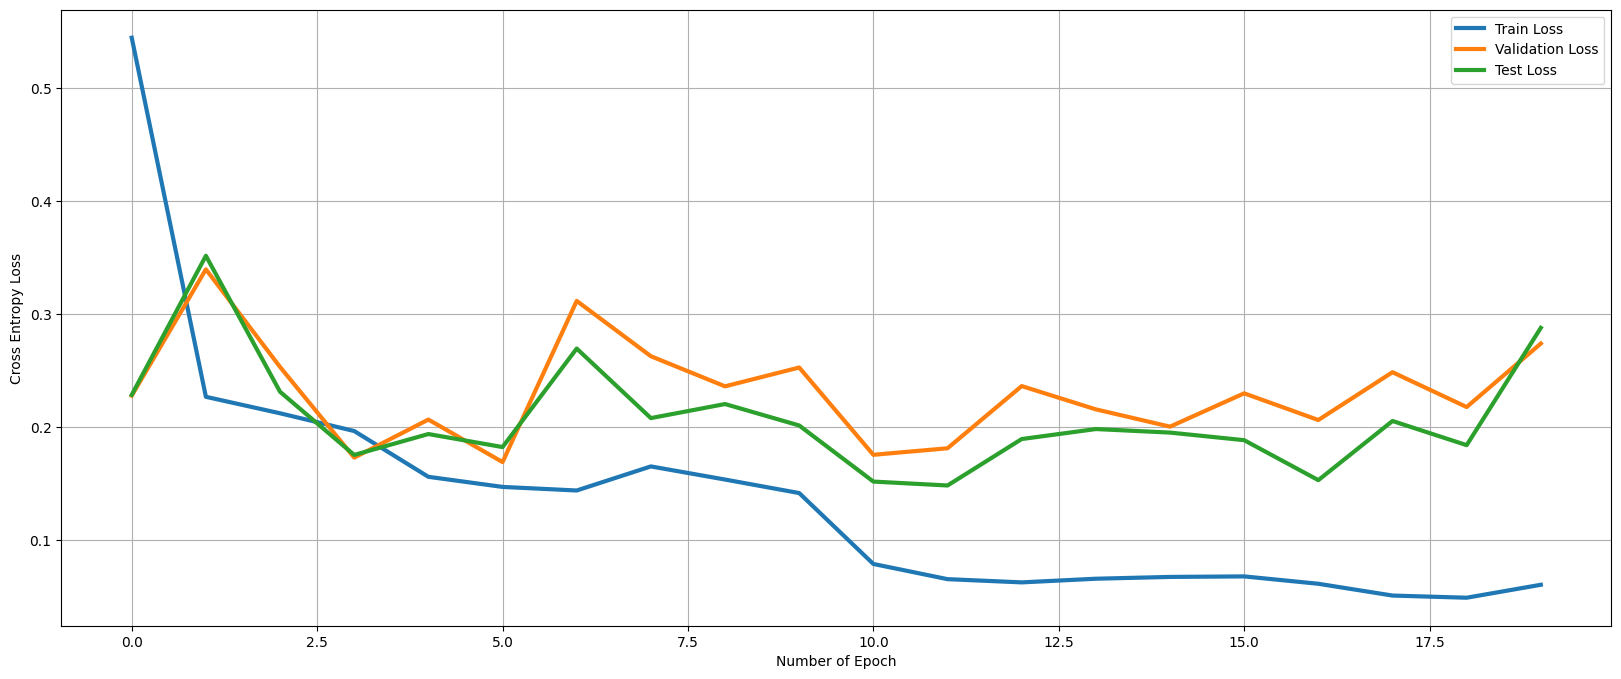

In [ ]:
plot_result(train_losses, valid_losses, test_losses)

## Underfitting Graph

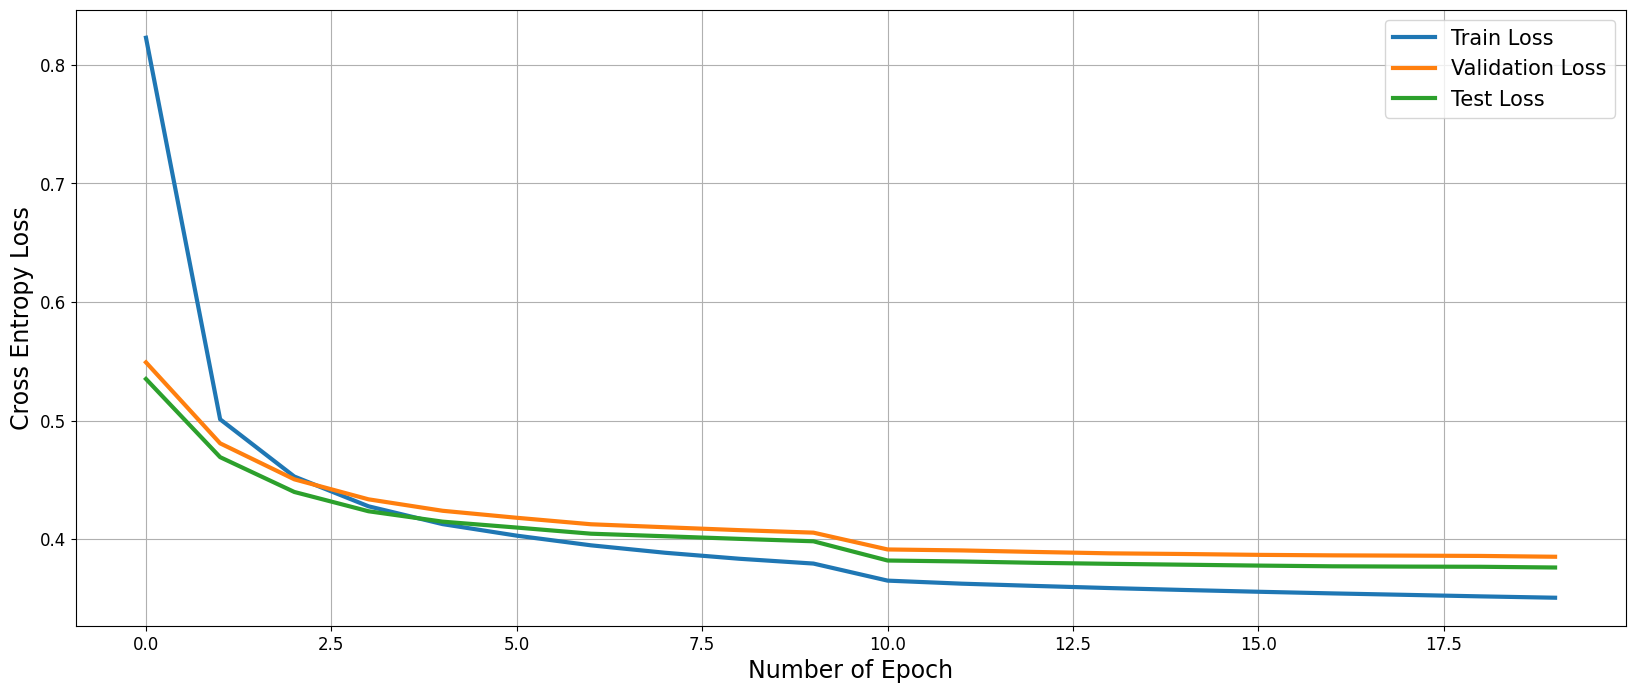

In [ ]:
plot_result(train_losses_2, valid_losses_2, test_losses_2)

# 과제 2

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 27518723.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  dog plane   car  frog


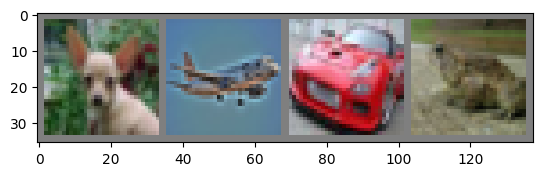

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # 표준화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

#해당 부분은 어느 정도 CNN의 개념이 포함되어 있습니다! 과제를 수행하는데 아무 관련도 없으니 그대로 두시면 됩니다!
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #아래 부분의 코드를 수정 혹은 추가해주시면 됩니다! (layer를 추가할때는 self.fc'num'=nn.Linear(x,y)의 형태로 추가하시면 됩니다!)
        self.fc1 = nn.Linear(400, 120) # input features, output features
        self.fc2 = nn.Linear(120, 48)
        self.fc3 = nn.Linear(48, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        #아래 부분에서 코드를 수정하거나 추가하여 forward 함수를 새롭게 지정해주시기 바랍니다!
        #Hint: relu 함수는 출력층을 제외한 모든 층에서 활성화 함수로써 작동되어야 합니다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

#optimizer를 변경하거나 수치를 조정해보는 것도 accuracy를 높이는 데 도움을 줄 수 있습니다!
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [8]:
for epoch in range(4):  # 데이터셋을 n차례 반복하여 학습합니다. 또한 range 속의 숫자도 바꾸어 학습률을 높이는 것도 도움이 될 겁니다!

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data
        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력

        running_loss += loss.item()
        # 2000개의 data를 학습할때마다 loss 출력
        if i % 2000 == 1999:    # % 뒤에 들어갈 숫자의 크기를 조정하여 batch_size를 조정할 수 있습니다! 그리고 i % n == n-1:로 숫자를 맞춰주셔야 한다는 점 잊지 마세요!
            print('[%d, %5d] epoch loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) # running_loss 우측의 숫자 역시 윗줄에서 바꾼 batch_size로 바꿔주어야 합니다!
            running_loss = 0.0

print('Finished Training')

[1,  2000] epoch loss: 2.308
[1,  4000] epoch loss: 2.302
[1,  6000] epoch loss: 2.291
[1,  8000] epoch loss: 2.121
[1, 10000] epoch loss: 1.973
[1, 12000] epoch loss: 1.895
[2,  2000] epoch loss: 1.798
[2,  4000] epoch loss: 1.742
[2,  6000] epoch loss: 1.698
[2,  8000] epoch loss: 1.651
[2, 10000] epoch loss: 1.606
[2, 12000] epoch loss: 1.569
[3,  2000] epoch loss: 1.511
[3,  4000] epoch loss: 1.494
[3,  6000] epoch loss: 1.454
[3,  8000] epoch loss: 1.423
[3, 10000] epoch loss: 1.400
[3, 12000] epoch loss: 1.401
[4,  2000] epoch loss: 1.337
[4,  4000] epoch loss: 1.313
[4,  6000] epoch loss: 1.293
[4,  8000] epoch loss: 1.286
[4, 10000] epoch loss: 1.272
[4, 12000] epoch loss: 1.266
Finished Training


GroundTruth:    cat  ship  ship plane


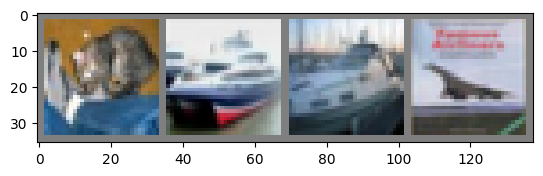

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [10]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship truck  ship


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 69 %
Accuracy of  bird : 32 %
Accuracy of   cat : 42 %
Accuracy of  deer : 54 %
Accuracy of   dog : 35 %
Accuracy of  frog : 69 %
Accuracy of horse : 65 %
Accuracy of  ship : 85 %
Accuracy of truck : 59 %


# 과제 3

MLP model과 기존 ML model의 차이점을 최소 2가지 측면에서 서술하기.

1. 모델을 구축하는 과정에서 ML은 데이터의 어떤 feature를 가공해서 사용할 것인가를 사용자가 직접 설정해줘야 하지만, MLP 같은 딥러닝 모델은 이 부분을 알아서 처리해줍니다. ML은 제가 내린 결정에 대한 결과를 직접 확인하고 다시 FE를 진행해 더 나은 결과를 도출할 수 있겠지만, MLP는 히든 레이어 안에서 무슨 일이 일어나는지 알 수 없는 블랙 박스와도 같습니다. </br>
2. ML은 선형회귀 같은 선형 모델을 주로 사용하지만, MLP는 여러개의 히든 레이어를 이용해서 활성화 함수에 레이어 마다 다양한 변화를 줄 수 있고, 그 결과물들을 전부 합쳐서 직선으로 표현할 수 없는 복잡한 식들을 재현할 수 있습니다.